In [1]:
# 采用LM326 678910月份数据，该数据没有缺失
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from pyecharts import HeatMap
df = pd.read_csv('./data/HE_2013_M25_59_1_10.csv', delimiter=';', parse_dates=['date_time'])  # 59条链路，1-10月原始数据
df = df.drop(['Local_Date', 'Local_Time', 'Day_Type_ID'], axis=1)  # 删除部分无关字段
df.columns = ['link_ID', 'date', 'length', 'flow', 'travel_time', 'speed', 'q', 'travel_time_log']  # 重命名
df = df.loc[(df.link_ID == 'LM326') & 
            (df.date.dt.month.isin([6, 7, 8, 9, 10]))
           ]
df = df.sort_values(by='date').reset_index()
df = df.drop(['index'], axis=1)  # 删除index
# print df.count()
df.head()

,link_ID,date,length,flow,travel_time,speed,q,travel_time_log
0,LM326,2013-06-01 00:00:00,1019.999981,166.0,39.41,93.18,1.0,3.699077
1,LM326,2013-06-01 00:15:00,1019.999981,150.0,38.35,95.74,1.0,3.672496
2,LM326,2013-06-01 00:30:00,1019.999981,141.0,40.51,90.65,1.0,3.725934
3,LM326,2013-06-01 00:45:00,1019.999981,124.0,39.72,92.44,1.0,3.706719
4,LM326,2013-06-01 01:00:00,1019.999981,112.0,38.13,96.31,1.0,3.666889


In [2]:
from pyecharts import HeatMap

def draw_heatmap(series, name='热力图', min_max=None):
    '''
    绘制日历热力图
    series.index为连续日期
    series.values为每天的值
    '''
    date_index = pd.date_range('2013-01-01 00:00:00', '2013-12-31 23:45:00',
                               freq='D').map(lambda x: x.strftime('%Y-%m-%d'))
    # 可能存在
    series = series.reindex(index=date_index)
    data = zip(list(series.index), series.values)
    if min_max:
        min_ = min_max[0]
        max_ = min_max[1]
    else:
        min_ = int(series.min()) / 10 * 10
        max_ = (int(series.max())/10 + 1) * 10
    heatmap = HeatMap(name, '日历热力图', width=900)
    heatmap.add('', data, is_calendar_heatmap=True,
                visual_text_color='#000', visual_range_text=['', ''],
                visual_range=[min_, max_], calendar_cell_size=['auto', 20],
                is_visualmap=True, calendar_date_range='2013',
                visual_orient="horizontal", visual_pos="center",
                visual_top="60%", is_piecewise=True)
    return heatmap

In [3]:
df['ymd'] = df.date.map(lambda x: x.strftime('%Y-%m-%d'))
mean_day_travel_time = df.groupby('ymd')['travel_time_log'].mean()
draw_heatmap(mean_day_travel_time, '每天平均旅行时间', min_max=[3.5, 4])

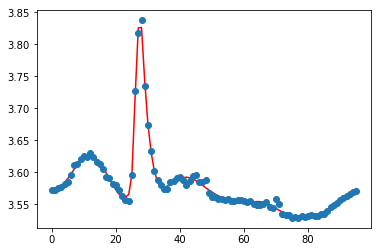

In [4]:
from scipy.interpolate import UnivariateSpline
df['hour_minute'] = df.date.map(lambda x: x.strftime('%H-%M'))
tmp = df.groupby('hour_minute').mean().reset_index()
spl = UnivariateSpline(tmp.index, tmp['travel_time_log'].values, s=0.002, k=3)
plt.plot(tmp.index, spl(tmp.index), 'r', tmp.index, tmp['travel_time_log'], 'o')
plt.show()

In [62]:
df[['link_ID', 'date', 'travel_time_log', 'travel_time', 'flow', 'speed', 'length', 'q']].to_csv(
    './data/HE_2013_M25LM326_6_10.csv', header=True, index=None, sep=';', mode='w')

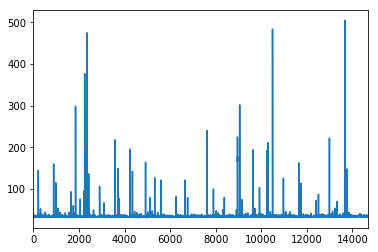

In [13]:
df['travel_time'].plot()
plt.show()

In [21]:
import pandas as pd
import numpy as np
from time import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from math import sqrt
from sklearn.metrics import mean_squared_error


def load_data(file_path, seq_len=50):
    global T_MIN, T_MAX
    df = pd.read_csv(file_path, delimiter=';', parse_dates=['date'])
    T_MIN = df['length'][0]*3.6/120
    T_MAX = df['travel_time'].max()
    # log ?
    df['travel_time_normalise'] = df['travel_time'].map(lambda x: (x-T_MIN) / (T_MAX-T_MIN))

    data = df['travel_time_normalise'].values
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    print('>>> shape of x_train (%d, %d, %d)' % x_train.shape)
    print('>>> shape of y_train (%d,)' % y_train.shape)
    # print('>>> shape of x_test (%d, %d, %d)' % x_test.shape)
    # print('>>> shape of y_test (%d,)' % y_test.shape)
    return [x_train, y_train, x_test, y_test]


def build_model(timestep=50, features=1, hidden=100, output=1):
    model = Sequential()

    model.add(LSTM(
        input_shape=(timestep, features),
        units=timestep,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        units=hidden,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=output))
    model.add(Activation("linear"))

    start = time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time() - start)
    return model

In [29]:
T_MIN, T_MAX = 30, 510
global_start_time = time()
epochs = 1
seq_len = 50
features = 1
hidden = 100
output = 1
print('>>> loading data... ')
X_train, y_train, X_test, y_test = load_data('data/HE_2013_M25LM326_6_10.csv',
                                             seq_len=seq_len)
print('>>> Data Loaded. Compiling...')
model = build_model(seq_len, features, hidden, output)

# verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
model.fit(X_train, y_train,
          batch_size=512,
          epochs=epochs,
          validation_split=0.1,
          verbose=1)

# predict
predicted = model.predict(X_test)
predicted = predicted.flatten() * (T_MAX - T_MIN) + T_MIN
y_test = y_test * (T_MAX - T_MIN) + T_MIN
rmse = sqrt(mean_squared_error(y_test, predicted))
print('Test RMSE: %.3f' % rmse)
mre = get_mre(y_test, predicted)
print('Test MRE: %.3f' % mre)

>>> loading data... 
>>> shape of x_train (13173, 50, 1)
>>> shape of y_train (13173,)
>>> Data Loaded. Compiling...
> Compilation Time :  0.025068283081054688
Train on 11855 samples, validate on 1318 samples
Epoch 1/1
11855/11855 [==============================] - 4s - loss: 0.0012 - val_loss: 3.9636e-04
Test RMSE: 19.228
Test MRE: 0.054


In [1]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import backend as K
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [6]:
df = pd.read_csv('data/HE_2013_M25LM326_6_10.csv', delimiter=';', parse_dates=['date'])
data = df['travel_time'].values
row_9 = round(0.9 * data.shape[0])
train = data[:int(row_9)]
test
print(train.shape)

(13219,)
